<center>
    <h1>Image Deblurring</h1>
    <h2>Deep Learning - 10 June 2022</h2>
    <h3>Riccardo Spolaor (0001032802)</h3>
    <h4>Email: riccardo.spolaor@studio.unibo.it</h4>
</center>

# Assignment
## Task 

The task consists of creating a deep learning model to detect hate speech or offensive language in texts. Try to build a pipeline which is able to perform the task and evaluate the results obtained. Make sure to test the model in order to prove robustness and lack of overfitting. 

The metric you will need to use to evaluate the results is the *MSE*. The metrics will be evaluated on the reconstructed images, so provide a way to check the results on a batch composed of original images and reconstructed images.

## Dataset
The dataset is built starting from *CIFAR-10* images collection. Feel free to further split the data to build a validation set, if needed. The split into different data split is left to you, perform it as you like, making sure it is meaningful.

### Dataset creation - DO NOT MODIFY

In [1]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
    (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
    normalize = lambda x: x/x.max()
    x_train = normalize(x_train)
    x_test = normalize(x_test)
    createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
    return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

# Solution

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

## Data visualization

In [58]:
(x_train, y_train), (x_test, y_test) = getDataset()

In [59]:
print(f'The shape of the x_train dataset is: {x_train.shape}')
print(f'The shape of the y_train dataset is: {y_train.shape}')

print(f'The shape of the x_test dataset is: {x_test.shape}')
print(f'The shape of the y_test dataset is: {y_test.shape}')

The shape of the x_train dataset is: (50000, 32, 32, 3)
The shape of the y_train dataset is: (50000, 32, 32, 3)
The shape of the x_test dataset is: (10000, 32, 32, 3)
The shape of the y_test dataset is: (10000, 32, 32, 3)


In [82]:
def plot_images_comparison(images_dataset_1, images_dataset_2, main_title, title_1, title_2):
    fig = plt.figure(figsize=(16,8))
    
    fig.suptitle(main_title, fontsize=14)

    grid1 = ImageGrid(fig, 121, (3, 3), axes_pad=.05, share_all=True)
    grid2 = ImageGrid(fig, 122, (3, 3), axes_pad=.05, share_all=True)

    #plt.tight_layout(w_pad=3)

    grid1.axes_all[1].set_title(title_1)
    grid2.axes_all[1].set_title(title_2)
    
    for ax, im in zip(grid1, images_dataset_1):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    for ax, im in zip(grid2, images_dataset_2):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #fig.set_tight_layout(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


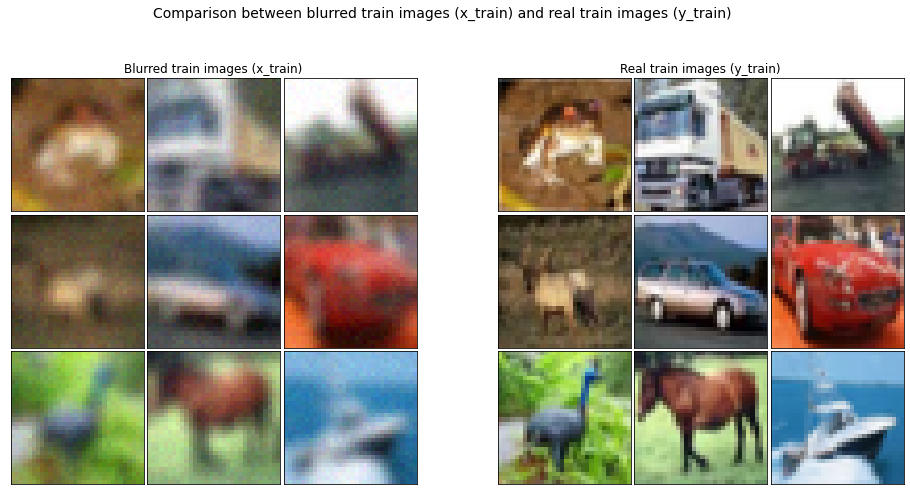

In [83]:
plot_images_comparison(
    x_train, y_train,
    'Comparison between blurred train images (x_train) and real train images (y_train)', 
    'Blurred train images (x_train)', 'Real train images (y_train)'
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


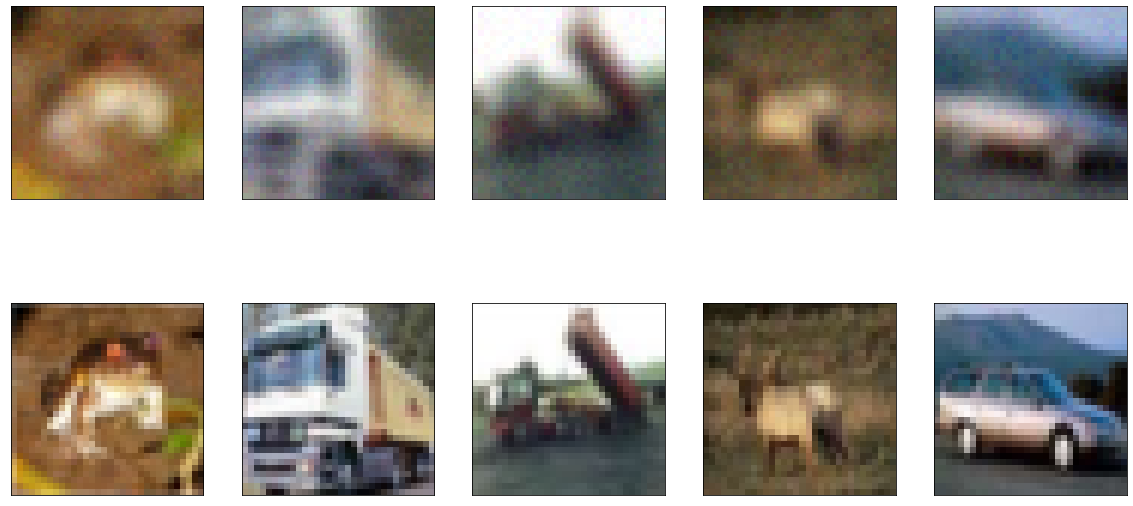

In [7]:
def plot_first_images(n_images_to_plot=5):
    plt.figure(figsize=(20, 10))
    for i in range(n_images_to_plot):
        # Display blurrd image
        ax = plt.subplot(2, n_images_to_plot, i + 1)
        plt.imshow(x_train[i], vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed image
        ax = plt.subplot(2, n_images_to_plot, i + 1 + n_images_to_plot)
        plt.imshow(y_train[i], vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
plot_first_images()

In [41]:
def eam(input_layer, channels, reduction_ratio=8):
    # First branch dilated convolutions
    x = layers.Conv2D(channels, 3, dilation_rate=1, padding='same',activation='relu')(input_layer)
    x = layers.Conv2D(channels, 3, dilation_rate=2, padding='same',activation='relu')(x)

    # Second branch dilated convolutions
    y = layers.Conv2D(channels, 3, dilation_rate=3, padding='same',activation='relu')(input_layer)
    y = layers.Conv2D(channels, 3, dilation_rate=4, padding='same',activation='relu')(y)

    # Concatenate the branches apply a convolution and add residual connection with the input 
    z = layers.Concatenate(axis=-1)([x,y])
    z = layers.Conv2D(channels, 3, padding='same')(z)
    z = layers.Add()([z, input_layer])
    act_b1 = layers.Activation('relu')(z)

    # Convolve add residual with the result of the previous block and activate with ReLU 
    x = layers.Conv2D(channels, 3, padding='same', activation='relu')(act_b1)
    x = layers.Conv2D(channels, 3, padding='same')(x)
    x = layers.Add()([x, z])
    act_b2 = layers.Activation('relu')(x)

    # Convolve add residual with the result of the previous block and activate with ReLU
    x = layers.Conv2D(channels, 3, padding='same',activation='relu')(act_b2)
    x = layers.Conv2D(channels, 3, padding='same',activation='relu')(x)
    x = layers.Conv2D(channels, 1)(x)
    x = layers.Add()([x, act_b2])
    act_b3 = layers.Activation('relu')(x)

    # Apply squeeze and excitation attention
    att = layers.GlobalAveragePooling2D(keepdims=True)(act_b3)
    h_d = layers.Conv2D(channels // reduction_ratio, 3, padding='same', activation='relu')(att)
    h_u = layers.Conv2D(channels, 3, padding='same',activation='sigmoid')(h_d)
    output_layer = layers.Multiply()([h_u, act_b3])

    return output_layer

def ridnet(input_shape, channels=64):
    input_layer = layers.Input(input_shape)
    
    # Extract features
    feature_extraction = layers.Conv2D(channels, 3, padding='same')(input_layer)
    
    # Learn features with residual connections blocks
    eam_1 = eam(feature_extraction, channels)
    eam_2 = eam(eam_1, channels)
    eam_3 = eam(eam_2, channels)
    eam_4 = eam(eam_3, channels)
    
    # Reconstruct and add residual connection with the input layer
    add_1 = layers.Add()([eam_4, feature_extraction])
    act = layers.Activation('relu')(add_1)
    reconstruction = layers.Conv2D(3, 3, padding='same')(act)
    add_2 = layers.Add()([reconstruction, input_layer])
  
    # Build the model
    model = Model(input_layer, add_2)
    return model

model = ridnet(x_train.shape[1:])

In [42]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_250 (Conv2D)            (None, 32, 32, 64)   1792        ['input_7[0][0]']                
                                                                                                  
 conv2d_251 (Conv2D)            (None, 32, 32, 64)   36928       ['conv2d_250[0][0]']             
                                                                                                  
 conv2d_253 (Conv2D)            (None, 32, 32, 64)   36928       ['conv2d_250[0][0]']             
                                                                                            

 conv2d_270 (Conv2D)            (None, 32, 32, 64)   36928       ['activation_64[0][0]']          
                                                                                                  
 conv2d_271 (Conv2D)            (None, 32, 32, 64)   36928       ['conv2d_270[0][0]']             
                                                                                                  
 conv2d_272 (Conv2D)            (None, 32, 32, 64)   4160        ['conv2d_271[0][0]']             
                                                                                                  
 add_72 (Add)                   (None, 32, 32, 64)   0           ['conv2d_272[0][0]',             
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_65 (Activation)     (None, 32, 32, 64)   0           ['add_72[0][0]']                 
          

                                                                                                  
 add_76 (Add)                   (None, 32, 32, 64)   0           ['conv2d_291[0][0]',             
                                                                  'multiply_22[0][0]']            
                                                                                                  
 activation_69 (Activation)     (None, 32, 32, 64)   0           ['add_76[0][0]']                 
                                                                                                  
 conv2d_292 (Conv2D)            (None, 32, 32, 64)   36928       ['activation_69[0][0]']          
                                                                                                  
 conv2d_293 (Conv2D)            (None, 32, 32, 64)   36928       ['conv2d_292[0][0]']             
                                                                                                  
 add_77 (A

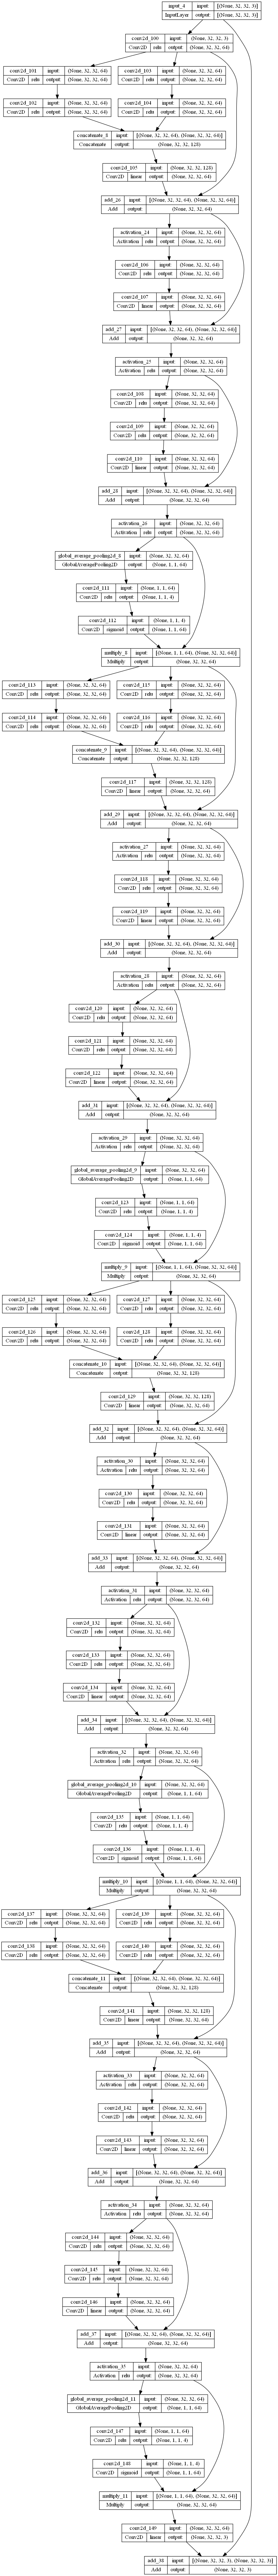

In [29]:
plot_model(model, show_shapes=True, show_layer_activations=True)

In [32]:
one_norm_loss = lambda y_true, y_pred: tf.norm(y_true - y_pred, ord=1, axis=-1)

In [33]:
adam = Adam(0.001, beta_1=0.1)
model.compile(optimizer=adam, loss=one_norm_loss, metrics=["mse"])

In [34]:
WEIGHTS_DIRECTORY_PATH = './weights/'
WEIGHTS_FILE_PATH = os.path.join(WEIGHTS_DIRECTORY_PATH, 'weights.h5')

os.makedirs(os.path.dirname(WEIGHTS_DIRECTORY_PATH), exist_ok=True)

In [35]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_mse',
    filepath=WEIGHTS_FILE_PATH,
    save_best_only=True,
    save_weights_only=True
)

In [37]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=64, callbacks=[model_checkpoint])

Epoch 1/20
625/625 [==============================] - 141s 220ms/step - loss: 0.1430 - mse: 0.0046 - val_loss: 0.1250 - val_mse: 0.0034
Epoch 2/20
625/625 [==============================] - 137s 220ms/step - loss: 0.1213 - mse: 0.0032 - val_loss: 0.1151 - val_mse: 0.0029
Epoch 3/20
625/625 [==============================] - 137s 219ms/step - loss: 0.1161 - mse: 0.0029 - val_loss: 0.2302 - val_mse: 0.0101
Epoch 4/20
625/625 [==============================] - 135s 216ms/step - loss: 34.6126 - mse: 83632.3359 - val_loss: 0.1709 - val_mse: 0.0067
Epoch 5/20
269/625 [===========>..................] - ETA: 1:10 - loss: 0.1721 - mse: 0.0068

KeyboardInterrupt: 

In [66]:
model.load_weights(WEIGHTS_FILE_PATH)

In [67]:
def plot_training_history(key):
    plt.plot(history.history[key])
    plt.plot(history.history[f'val_{key}'])
    plt.title(f'Model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

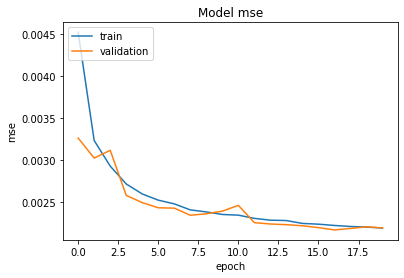

In [68]:
plot_training_history('mse')

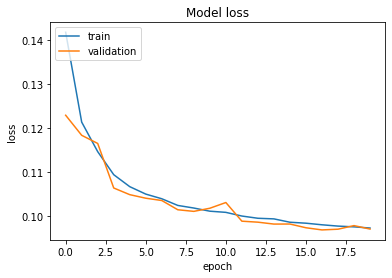

In [69]:
plot_training_history('loss')

In [26]:
predictions = model.predict(x_test)

313/313 [==============================] - 12s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


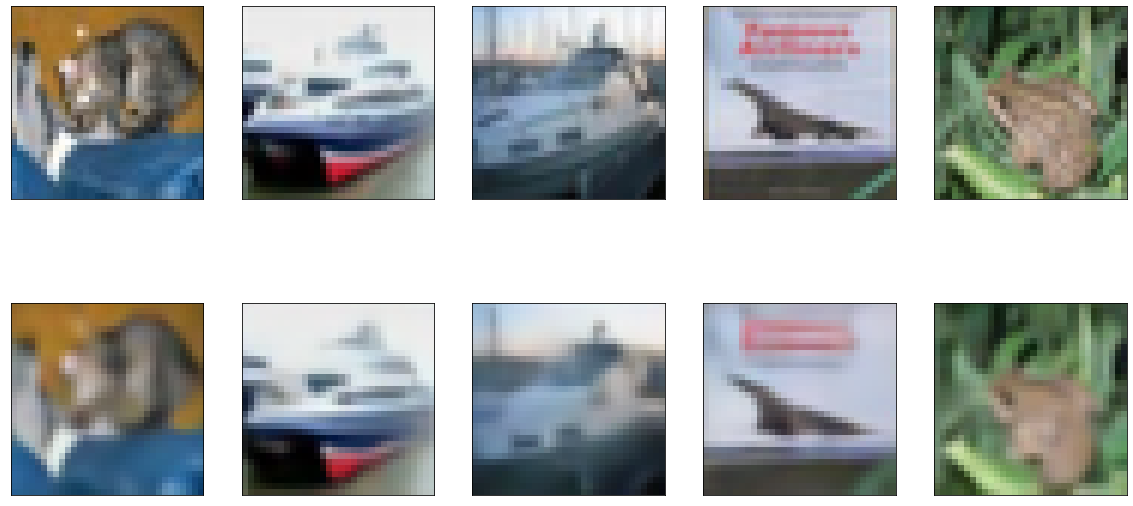

In [29]:
plot_images_comparison(
    x_test, predictions,
    'Comparison between blurred test images (x_test) and predicted real test images (predictions)', 
    'Blurred test images (x_test)', 'Predicted real test images (predictions)'
)

In [ ]:
plot_images_comparison(
    y_test, predictions,
    'Comparison between real test images (x_test) and predicted real test images (predictions)', 
    'Real test images (y_test)', 'Predicted real test images (predictions)'
)

plot_images_comparison(x_test, predictions, 'Real test images', 'Predicted real test images')

In [30]:
mse = MeanSquaredError()
resulting_mse = mse(y_test, predictions).numpy()
print(f'The mean squared error between the images reconstructed by the model (predictions) and the real images of the test set (y_test) is: {resulting_mse}')

0.0021835747